<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Word_embeddings_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [6]:
pip install fastbook
pip install dtreeviz

     |████████████████████████████████| 62 kB 654 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67936 sha256=5acfa2b38670715bd03d0773fb1b09a38760ebe006e3ca22ac8af2a9a0d3e5b5
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz


In [3]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [7]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data

In [65]:
path = "MyDrive/archivos_tfm/ch1_train_combination_and_monoTherapy.csv"
df = pd.read_csv(path, low_memory=False)

In [24]:
df.head(5)

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,...,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-20,ADAM17,AKT,1.0,...,91.593425,29.540390,1,ADAM17.AKT
1,CAL-120,ADAM17,AKT,1.0,...,100.000000,4.401410,-1,ADAM17.AKT
2,CAL-51,ADAM17,AKT,1.0,...,76.656479,0.315422,1,ADAM17.AKT
3,DU-4475,ADAM17,AKT,1.0,...,6.171007,-41.734090,-1,ADAM17.AKT
4,HCC1143,ADAM17,AKT,1.0,...,100.000000,35.532770,-1,ADAM17.AKT


In [66]:
df.columns


Index(['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B', 'MAX_CONC_A', 'MAX_CONC_B',
       'IC50_A', 'H_A', 'Einf_A', 'IC50_B', 'H_B', 'Einf_B', 'SYNERGY_SCORE',
       'QA', 'COMBINATION_ID'],
      dtype='object')

In [67]:
# A little bit of data analysis
df.describe()

,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,...,H_B,Einf_B,SYNERGY_SCORE,QA
count,2199.000000,2199.000000,2199.000000,2199.000000,...,2199.000000,2199.000000,2199.000000,2199.000000
mean,1.720737,4.956294,0.731751,3.105960,...,3.047802,48.997472,8.620195,0.573897
std,1.825276,14.636863,1.031314,3.799118,...,3.796168,36.470083,152.441899,0.946172
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-588.220700,-3.000000
25%,1.000000,1.000000,0.072514,0.477673,...,0.419456,12.548219,-8.146240,1.000000
50%,1.000000,1.000000,0.344153,1.327347,...,1.234519,48.200072,7.070362,1.000000
75%,3.000000,3.000000,1.000000,3.662533,...,3.553217,84.801210,25.385300,1.000000
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,6737.175000,1.000000


In [68]:
dep_var = 'SYNERGY_SCORE'


In [69]:
procs = [Categorify, FillMissing]


In [70]:
# We shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df[1:5]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,...,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
1,BT-549,AKT_SGK,MAP2K_1,1.0,...,33.803112,28.687710,1,AKT_SGK.MAP2K_1
2,HCC1187,ESR1,FGFR,1.0,...,100.000000,2.281585,1,ESR1.FGFR
3,NCI-H1299,ALK,CSNK2A1_2,0.1,...,0.000000,31.100960,1,ALK.CSNK2A1_2
4,TCCSUP,ATR_4,HDAC_4,3.0,...,0.000000,9.202446,1,ATR_4.HDAC_4


In [77]:
# We will erase Combination ID as it offers no additional information
# We only want perfect samples, so only QA = 1

df_nocomb = df.drop(["COMBINATION_ID"], 1)
df_def = df_nocomb[df_nocomb['QA'] == 1]
df_def.describe()

,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,...,H_B,Einf_B,SYNERGY_SCORE,QA
count,1795.000000,1795.000000,1795.000000,1795.000000,...,1795.000000,1795.000000,1795.000000,1795.0
mean,1.717631,4.883179,0.706264,2.793713,...,2.770852,46.922222,12.747145,1.0
std,1.792137,14.521648,0.961016,3.535241,...,3.561374,35.548909,27.568933,0.0
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-178.654100,1.0
25%,1.000000,1.000000,0.067338,0.555720,...,0.480006,11.918153,-2.777218,1.0
50%,1.000000,1.000000,0.329907,1.265459,...,1.183510,45.741680,9.755133,1.0
75%,3.000000,3.000000,1.000000,2.784385,...,2.768540,80.649374,27.136630,1.0
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,237.376400,1.0


In [78]:
# We create the train/validation splits
dataset_size = df_def.shape[0]
cutoff = int(dataset_size * 0.7)
train_idx = df_def.index[:cutoff] 
valid_idx = df_def.index[cutoff:] 

splits = (list(train_idx),list(valid_idx))

In [79]:
cont,cat = cont_cat_split(df_def, 1, dep_var=dep_var)
to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [80]:
len(to.train),len(to.valid)

(1256, 539)

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Baseline model: mean and median

In [102]:
train_df = df_def[:cutoff]
train_df.describe()

,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,...,H_B,Einf_B,SYNERGY_SCORE,QA
count,1256.000000,1256.000000,1256.000000,1256.000000,...,1256.000000,1256.000000,1256.000000,1256.0
mean,1.665285,4.901166,0.713724,2.833716,...,2.748656,46.903867,12.908007,1.0
std,1.705173,14.509809,1.016749,3.563914,...,3.536122,35.387150,27.827562,0.0
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-178.654100,1.0
25%,1.000000,1.000000,0.048578,0.555956,...,0.477057,12.740515,-2.074869,1.0
50%,1.000000,1.000000,0.328799,1.264913,...,1.185464,45.010395,9.520950,1.0
75%,3.000000,3.000000,1.000000,2.823871,...,2.786789,79.996054,26.336540,1.0
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,237.376400,1.0


  Let's see how good it performs a model whose only information is the median

In [103]:
mean = np.mean(train_df["SYNERGY_SCORE"])
median = np.median(train_df["SYNERGY_SCORE"])
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.5209495 
 Mean = 12.908007451246025


We create our metrics

In [104]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [105]:
error_mean = r_mse(mean, y)
error_median = r_mse(median, y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.021935 
 Error Mean = 27.816479





# Decision Trees


In [81]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

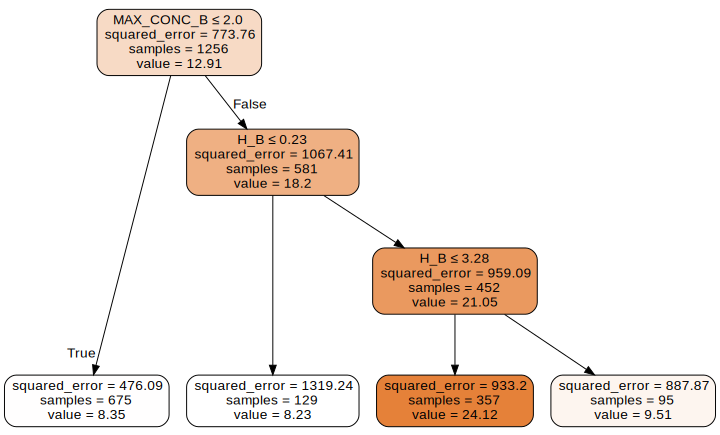

In [82]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


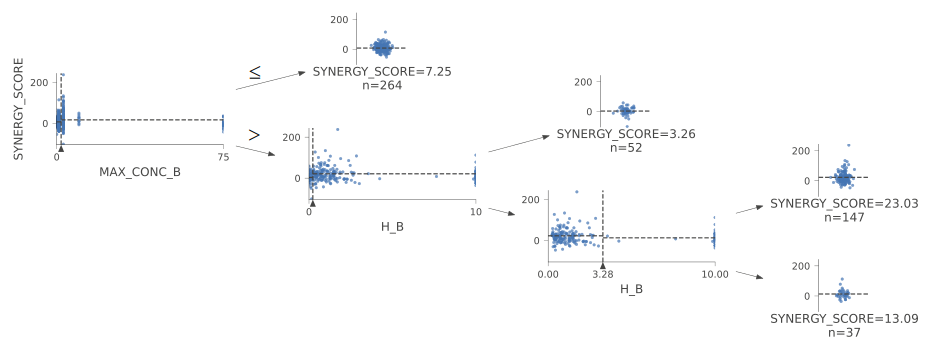

In [83]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [84]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [85]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [86]:
m_rmse(m, valid_xs, valid_y)


36.71587

Now we will check for overfitting:

In [87]:
m.get_n_leaves(), len(xs)

(1256, 1256)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [106]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(24.491832, 27.172862)

In [89]:
m.get_n_leaves()


38

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [115]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [121]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 67 
 Error = 26.347273


Not outstanding, barely better. We should try another algorithm

# Random Forest

In [122]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [123]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


(23.954833, 25.591036)

A little better than the Tree regressor, but not that great.

## Feature importance

In [124]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
10,H_B,0.135054
8,Einf_A,0.121427
0,CELL_LINE,0.115796
11,Einf_B,0.109108
6,IC50_A,0.095790
9,IC50_B,0.095712
7,H_A,0.089745
1,COMPOUND_A,0.078677
2,COMPOUND_B,0.075921
5,MAX_CONC_B,0.044502


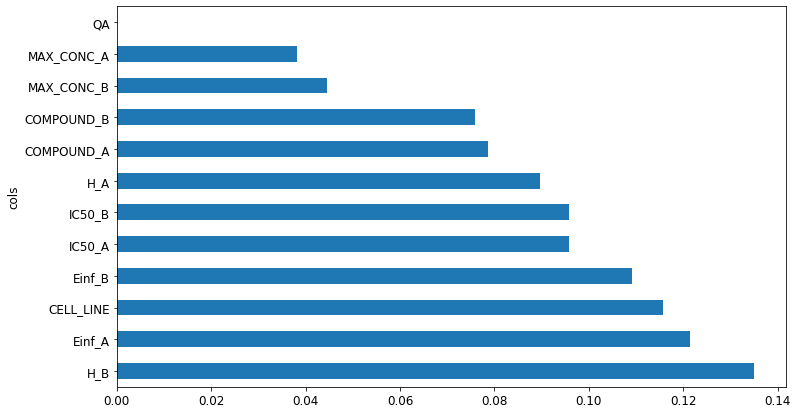

In [125]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Here we don't have a lot of columns, so we don't have
to erase any of them.